**2. 위의 문제에서 Convolution Layer(conv3), Fully connected layer(FC2) 를 1개씩
 추가하고, 정확도가 높아지는지 평가하라.**

Traning

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mnist = tf.keras.datasets.mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x, test_x = train_x/255.0, test_x/255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
train_x.shape

(60000, 28, 28)

In [4]:
train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

In [27]:
# input layer
input_h = 28   # input height
input_w = 28  # input width
input_ch = 1   # input channel : Gray scale


# 1st convolution layer
k1_h =3
k1_w =3
k1_ch =32
p1_h =2
p1_w =2
# (None, 14, 14, 32)

# 2nd convolution layer
k2_h =3
k2_w =3
k2_ch =64
p2_h =2
p2_w =2
# (None, 7, 7, 64)

# 3rd convolution layer
k3_h =3
k3_w =3
k3_ch =128
p3_h =2
p3_w =2
# (None, 4, 4, 128)

# Fully connected : flatten the features (4x4x128)
conv_result_size = 4 * 4 * 128  # Corrected calculation
n_hidden = 100
n_output = 10

In [28]:
# Kernel size : [kernel_height, kernel_width, input_ch, output_ch]
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

weights = {
    'conv1' : tf.Variable(tf.random.normal([k1_h, k1_w,input_ch, k1_ch], stddev = 0.1)), #height, width, in_channel, out_channel, stddev=표준편차
    'conv2' : tf.Variable(tf.random.normal([k2_h, k2_w, k1_ch, k2_ch], stddev = 0.1)),
    'conv3' : tf.Variable(tf.random.normal([k3_h, k3_w, k2_ch, k3_ch], stddev = 0.1)),
    'hidden' : tf.Variable(tf.random.normal([conv_result_size, n_hidden], stddev = 0.1)),
    'output' : tf.Variable(tf.random.normal([n_hidden, n_output], stddev = 0.1))
}

# bias size : [output_ch] or [neuron_size]
biases = {
    'conv1' : tf.Variable(tf.random.normal([k1_ch], stddev = 0.1)),
    'conv2' : tf.Variable(tf.random.normal([k2_ch], stddev = 0.1)),
    'conv3' : tf.Variable(tf.random.normal([k3_ch], stddev = 0.1)),
    'hidden' : tf.Variable(tf.random.normal([n_hidden], stddev = 0.1)),
    'output' : tf.Variable(tf.random.normal([n_output], stddev = 0.1))
}

# input layer : [batch_size, image_height, image_width, channels]
# output layer : [batch_size, class_size]
x = tf.placeholder(shape=[None, input_h, input_w, input_ch], dtype=tf.float32)
y = tf.placeholder(shape=[None, n_output], dtype=tf.float32)

In [29]:
# [batch, height, width, channels]

def net(x, weights, biases):
    # 1st conv + ReLU + MaxPool
    conv1 = tf.nn.conv2d(x, weights['conv1'], strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(tf.add(conv1, biases['conv1']))
    maxp1 = tf.nn.max_pool(conv1, ksize=[1,p1_h,p1_w,1], strides=[1,p1_h,p1_w,1], padding='VALID')

    # 2nd convolution layer
    # Corrected the strides argument to be a list [1,1,1,1] instead of trying to index a non-existent variable 'strides'
    conv2 = tf.nn.conv2d(maxp1, weights['conv2'], [1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(tf.add(conv2, biases['conv2']))
    maxp2 = tf.nn.max_pool(conv2, ksize=[1,p2_h,p2_w,1], strides=[1,p2_h,p2_w,1], padding='VALID')

    conv3 = tf.nn.conv2d(maxp2, weights['conv3'], [1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(tf.add(conv3, biases['conv3']))
    maxp3 = tf.nn.max_pool(conv3, ksize=[1,p3_h,p3_w,1], strides=[1,p3_h,p3_w,1], padding='SAME')

    # Flatten
    maxp3_flatten = tf.reshape(maxp3, [-1, conv_result_size])

    # Fully connected
    hidden = tf.add(tf.matmul(maxp3_flatten,weights['hidden']), biases['hidden'])
    hidden = tf.nn.relu(hidden)
    output = tf.add(tf.matmul(hidden, weights['output']), biases['output'])

    return output

In [30]:
# Loss function

LR = 0.0001
pred = net(x, weights, biases)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y)
loss = tf.reduce_mean(loss)

optm = tf.train.AdamOptimizer(learning_rate=LR).minimize(loss)

Iter : 0
Train Loss : 2.3335
Cost : 2.4758

Iter : 250
Train Loss : 0.5101
Cost : 0.5714

Iter : 500
Train Loss : 0.1137
Cost : 0.2203

Iter : 750
Train Loss : 0.1858
Cost : 0.2391

Iter : 1000
Train Loss : 0.1583
Cost : 0.1607

Iter : 1250
Train Loss : 0.1060
Cost : 0.1199

Iter : 1500
Train Loss : 0.0319
Cost : 0.0525

Iter : 1750
Train Loss : 0.4135
Cost : 0.0435

Iter : 2000
Train Loss : 0.0580
Cost : 0.0252

Iter : 2250
Train Loss : 0.0532
Cost : 0.0396



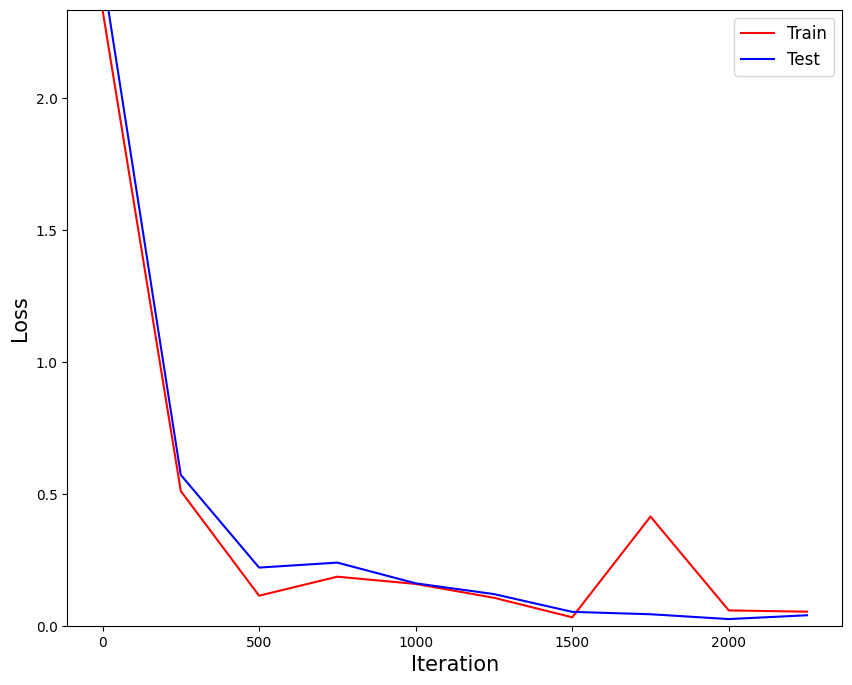

In [32]:
# Optimization

n_batch = 50
n_iter = 2500
n_prt = 250

sess = tf.Session()
sess.run(tf.global_variables_initializer())

loss_record_train = []
loss_record_test = []

for epoch in range(n_iter):

    #배치 추출
    # Get a random batch of training data
    batch_indices = np.random.choice(train_x.shape[0], n_batch, replace=False)
    batch_x = train_x[batch_indices]
    batch_y = tf.keras.utils.to_categorical(train_y[batch_indices], num_classes=10)

    sess.run(optm, feed_dict={x:batch_x, y:batch_y})

    if epoch % n_prt == 0:
        #테스트 배치 추출
        test_batch_indices = np.random.choice(test_x.shape[0], n_batch, replace=False)
        test_batch_x = test_x[test_batch_indices]
        test_batch_y = test_y[test_batch_indices]

        # Convert labels to one-hot encoding if necessary
        test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)
        c1 = sess.run(loss, feed_dict={x: batch_x, y: batch_y})
        c2 = sess.run(loss, feed_dict={x: test_batch_x, y: test_batch_y})

        loss_record_train.append(c1)
        loss_record_test.append(c2)
        print("Iter : {}".format(epoch))
        print("Train Loss : {:.4f}".format(c1))
        print("Cost : {:.4f}\n".format(c2))

plt.figure(figsize = (10,8))
plt.plot(np.arange(len(loss_record_train))*n_prt, loss_record_train, 'r', label = 'Train')
plt.plot(np.arange(len(loss_record_test))*n_prt, loss_record_test, 'b', label = 'Test')
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend(fontsize = 12)
plt.ylim([0, np.max(loss_record_train)])
plt.show()

Testing or Evaluating

In [33]:
# Evaluation
# Get a random batch of test data
test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
test_batch_x = test_x[test_batch_indices]
test_batch_y = test_y[test_batch_indices]

test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))  # Reshape the batch if needed
# Convert labels to one-hot encoding if necessary
test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)  # Adjust num_classes if needed

my_pred = sess.run(pred, feed_dict={x: test_batch_x.reshape(-1, 28, 28, 1)})
my_pred = np.argmax(my_pred, axis=1)

labels = np.argmax(test_batch_y, axis=1)

accr = np.mean(np.equal(my_pred, labels))
print("Accuracy : {}".format(accr*100))

Accuracy : 98.0


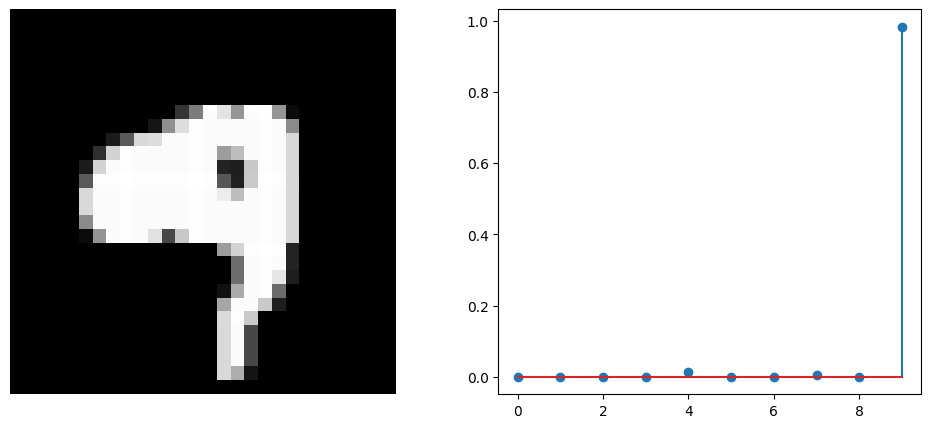

Prediction : 9
Probability : [0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.98]


In [34]:
# Get a random batch of test data
n_batch = 1
test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
test_batch_x = test_x[test_batch_indices]
test_batch_y = test_y[test_batch_indices]

test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))  # Reshape the batch if needed
# Convert labels to one-hot encoding if necessary
test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)  # Adjust num_classes if needed

logits = sess.run(tf.nn.softmax(pred), feed_dict={x: test_batch_x.reshape(-1, 28, 28, 1)})
predict = np.argmax(logits)

plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
plt.imshow(test_batch_x.reshape(28, 28), 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.stem(logits.ravel())
plt.show()

np.set_printoptions(precision = 2, suppress = True)
print('Prediction : {}'.format(predict))
print('Probability : {}'.format(logits.ravel()))

Iter : 0
Train Loss : 2.6103
Cost : 2.6983

Iter : 250
Train Loss : 0.3533
Cost : 0.4382

Iter : 500
Train Loss : 0.2656
Cost : 0.3382

Iter : 750
Train Loss : 0.2467
Cost : 0.1435

Iter : 1000
Train Loss : 0.0378
Cost : 0.0724

Iter : 1250
Train Loss : 0.1115
Cost : 0.1556

Iter : 1500
Train Loss : 0.1761
Cost : 0.0461

Iter : 1750
Train Loss : 0.0576
Cost : 0.0690

Iter : 2000
Train Loss : 0.0715
Cost : 0.0583

Iter : 2250
Train Loss : 0.1138
Cost : 0.1631



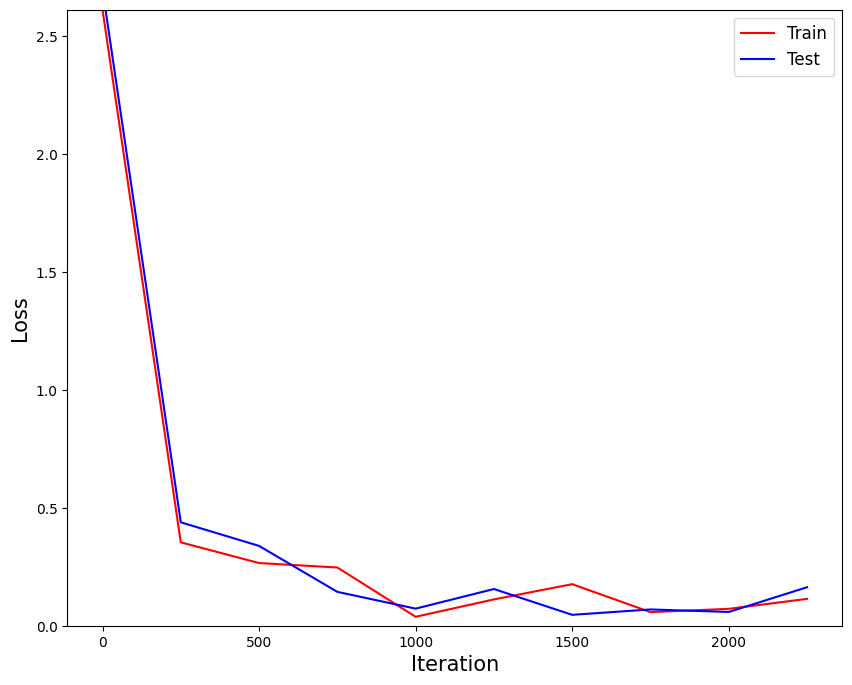

In [35]:
# Optimization

n_batch = 50
n_iter = 2500
n_prt = 250

sess = tf.Session()
sess.run(tf.global_variables_initializer())

loss_record_train = []
loss_record_test = []
for epoch in range(n_iter):
    # Use np.random.choice to get a random batch from the loaded data
    batch_indices = np.random.choice(train_x.shape[0], n_batch, replace=False)
    batch_x = train_x[batch_indices]
    batch_y = tf.keras.utils.to_categorical(train_y[batch_indices], num_classes=10) # Convert labels to one-hot encoding

    sess.run(optm, feed_dict={x:batch_x, y:batch_y})

    if epoch % n_prt == 0:
        # Get a random batch of test data
        test_batch_indices = np.random.choice(test_x.shape[0], n_batch, replace=False)
        test_batch_x = test_x[test_batch_indices]
        test_batch_y = test_y[test_batch_indices]

        # Reshape and one-hot encode the test batch
        test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))
        test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)

        c1 = sess.run(loss, feed_dict={x:batch_x, y:batch_y})
        c2 = sess.run(loss, feed_dict={x:test_batch_x, y:test_batch_y})

        loss_record_train.append(c1)
        loss_record_test.append(c2)
        print("Iter : {}".format(epoch))
        print("Train Loss : {:.4f}".format(c1)) # Use formatted string for better readability
        print("Cost : {:.4f}\n".format(c2))   # Use formatted string for better readability


plt.figure(figsize = (10,8))
plt.plot(np.arange(len(loss_record_train))*n_prt, loss_record_train, 'r', label = 'Train')
plt.plot(np.arange(len(loss_record_test))*n_prt, loss_record_test, 'b', label = 'Test')
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend(fontsize = 12)
plt.ylim([0, np.max(loss_record_train)])
plt.show()